# Predicting crime rate

In this notebook, we use a [seasonal ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average#Variations_and_extensions) to forecast crime in Chicago. To jump straight to the model, click [here](#forecast).

Our goal is to create a time series forecast for crime; we spend most of the notebook focused specifically on thefts. We have chosen to predict with a two year horizon, or two full seasons.

In the [first section](#setup), we load in our data, form the time series, and split into training and test sets. In the [next section](#selection), we choose our model, including selection of the parameters of the model through cross-validation. Our final forecast is [here](#forecast), where we show the results and also analyze the residuals to see if the model can still be improved. [Finally](#additional), we employ the same model to see if we can forecast different crimes, or crimes in specific neighborhoods instead of city-wide.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings
from datetime import datetime

## Set-up
<a id='setup'></a>
   
First we import the data of reported crimes in Chicago. For more, see notebooks [1](01-chicago-crime.ipynb) or [2](02-arrests.ipynb).

In [2]:
crimedata = pd.read_hdf('/home/elaad/Documents/DatAnalysis/datasets/chicago_crimes.hdf')

Now we create our time series based on the monthly crime rate.

In [3]:
# rather than the number per month, we take the mean daily rate per month,
# which is independent of the length of the month
thefts = (crimedata.loc[crimedata['Primary Type'] == 'THEFT'].resample('1D').size() # daily number
                                                             .resample('1M').mean()) # mean per month

In [4]:
# split into train and test data
# test data remains completely unseen until the end
train = thefts.loc[thefts.index < '2018']
test = thefts.drop(index=train.index)

## Model selection
<a id='selection'><a/>

### Seasonality

As seen in [the first notebook](01-chicago-crime.ipynb), there is a strong seasonality to the incidence of crimes, with a 1 year (12 month) period. This can be seen in the figure below.

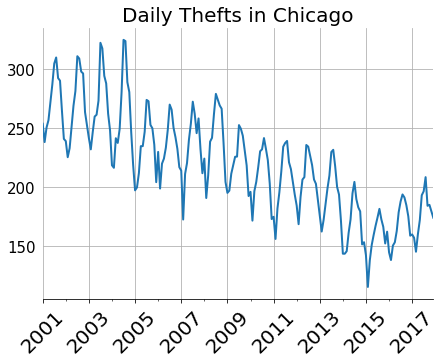

In [5]:
with plt.style.context('mplstyles/crimerate.mplstyle'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    train.plot(ax=ax, lw=2)
    ax.set_xlabel('')
    ax.set_title('Daily Thefts in Chicago')
    ax.tick_params(axis='x', labelsize=20, rotation=45)

### Log transformation

There seems to be an increase in variance at higher rates, so we will fit our ARIMA model to the log of the counts.

In [6]:
train = np.log10(train)
test = np.log10(test)

As seen in this small figure, the variance appears more constant after making the log transformation.

Text(0, 0.5, 'log daily theft rate')

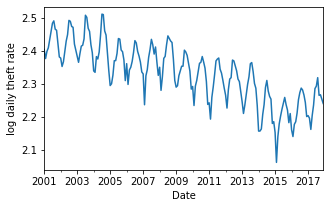

In [7]:
train.plot(figsize=(5, 3))
plt.ylabel('log daily theft rate')

This function is used below for plotting the time series and ACF + PACF.

In [8]:
def timegrid():
    """Return grid for plotting time series, ACF, + PACF"""
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2)
    tax = fig.add_subplot(gs[0, :])
    lax = fig.add_subplot(gs[1, 0])
    rax = fig.add_subplot(gs[1, 1])
    
    return fig, (tax, lax, rax)

### Identifying ARIMA order

The time series is seasonal (12 month) and non-stationary, so we take a seasonal difference and additionally try a first difference. Below we see the time series, autocorrelation, and partial autocorrelation --- first after only seasonal differencing, and then including a first differencing.

In the first plot, we see significant spikes in the PACF through lag 3, and decaying autocorrelation in the ACF, suggesting an AR(3) term. The negative spikes in the PACF at seasonal lags suggest we may need an additional seasonal MA(1) term as well.

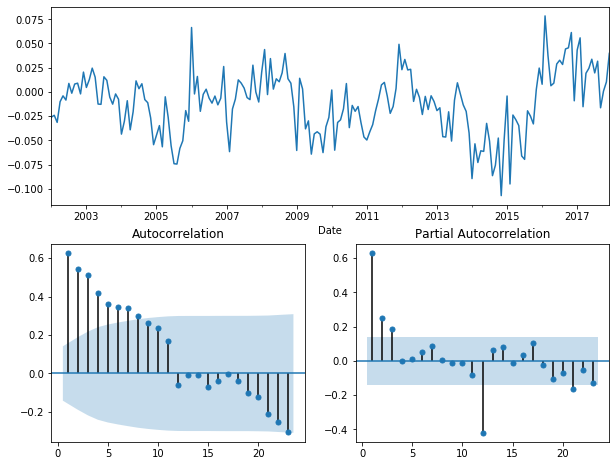

In [9]:
fig, ax = timegrid()
train.diff(12).dropna().plot(ax=ax[0])
plot_acf(train.diff(12).dropna(), zero=False, ax=ax[1])
plot_pacf(train.diff(12).dropna(), zero=False, ax=ax[2])
plt.show()

In the next plot, it looks like maybe a first difference _and_ a seasonal difference leads to overdifferencing. As shown in the cross-validation below, this doubly differenced time series indeed generally leads to worse results.

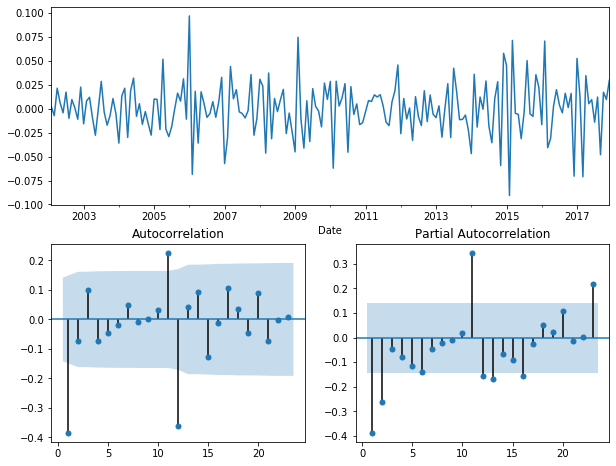

In [10]:
fig, ax = timegrid()
train.diff(12).diff().dropna().plot(ax=ax[0])
plot_acf(train.diff(12).diff().dropna(), zero=False, ax=ax[1])
plot_pacf(train.diff(12).diff().dropna(), zero=False, ax=ax[2])
plt.show()

### Finding the best model through cross-validation

Though we have a guess for our best model, we'll iterate through a few options and select the best one based on cross-validation. We do the cross-validation scoring in a function, `rmse_kfold`, and parallelize the search below. For the CV scores, we'll find the RMSE using k-fold (time series, non-random) splitting.

In [11]:
def rmse_kfold(series, m1, m2, horizon=12,
               do_kfold=False, return_all=False):
    """Calculate the RMSE and AIC of the training set
    
    series : the time series
    m1: (p, d, q) for the ARIMA model
    m2: (P, D, Q, s) for the seasonal ARIMA model
    do_kfold : if True, use k-fold CV (with time series splits)
               if False, do a single split
    return_all : if True, return the individual MSE scores
                 for each split instead of the average RMSE
                 
    Returns the RMSE (or MSE list) and the AIC
    """
    def calc_mse(true, pred):
        return 1./(len(true)) * ((true - pred)**2).sum()
    if do_kfold:
        # splitting training time series CV set
        # we want to split into units of our desired horizon
        kfold = TimeSeriesSplit(n_splits=(len(series) // horizon - 1))
        iterator = kfold.split(series)
    else:
        # just a single set of training indices and cv indices
        # training indices from 0 to -horizon, cv from -horizon to -1
        iterator = zip([np.arange(len(series) - horizon)], 
                       [np.arange(len(series) - horizon, len(series))])
    mse_list = []
    for train_ind, cv_ind in iterator:
        sarimax = SARIMAX(series.iloc[train_ind], order=m1, 
                          seasonal_order=m2, trend='c')
        sarimax_fit = sarimax.fit()
        mse_list.append(calc_mse(series.iloc[cv_ind],
                                 sarimax_fit.forecast(len([cv_ind]))))
    rmse = np.sqrt(np.mean(mse_list))
    return mse_list if return_all else rmse, sarimax_fit.aic

These are the models we will iterate through and evaluate.

In [12]:
# ARIMA(p, d, q)
pdq = [(3, 0, 0), (3, 0, 1), (2, 0, 0), (2, 0, 1),
       (3, 1, 0), (3, 1, 1), (2, 1, 0), (2, 1, 1)]

# seasonal ARIMA(P, D, Q, s)
PDQs = [(0, 1, 0, 12), (1, 1, 0, 12), (0, 1, 1, 12)]

Let's iterate over all combinations of models above, and store the RMSE and [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) values in a DataFrame. We suppress `statsmodel`'s warnings, and do the search on 4 processors.

In [13]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    models = pd.DataFrame(columns=['RMSE', 'AIC', 'ndiff'])
    futures = {}
    with ProcessPoolExecutor(4) as pool:
        for m1 in pdq:
            for m2 in PDQs:
                futures[pool.submit(rmse_kfold, train, m1, m2, 
                                    horizon=24, do_kfold=True)] = (m1, m2)
        for future in as_completed(futures):
            m1, m2 = futures[future]
            print(f'Processing model: {m1}, {m2}')
            rmse, aic = future.result()
            models = models.append(pd.Series({'RMSE':rmse, 
                                              'AIC':aic, 
                                              'ndiff':m1[1] + m2[1]}, 
                                             name=f'{m1},{m2}'))

Processing model: (3, 0, 0), (0, 1, 0, 12)
Processing model: (3, 0, 1), (0, 1, 0, 12)
Processing model: (3, 0, 0), (0, 1, 1, 12)
Processing model: (2, 0, 0), (0, 1, 0, 12)
Processing model: (3, 0, 0), (1, 1, 0, 12)
Processing model: (3, 0, 1), (1, 1, 0, 12)
Processing model: (3, 0, 1), (0, 1, 1, 12)
Processing model: (2, 0, 1), (0, 1, 0, 12)
Processing model: (2, 0, 0), (1, 1, 0, 12)
Processing model: (2, 0, 0), (0, 1, 1, 12)
Processing model: (3, 1, 0), (0, 1, 0, 12)
Processing model: (2, 0, 1), (1, 1, 0, 12)
Processing model: (3, 1, 0), (1, 1, 0, 12)
Processing model: (2, 0, 1), (0, 1, 1, 12)
Processing model: (3, 1, 1), (0, 1, 0, 12)
Processing model: (3, 1, 0), (0, 1, 1, 12)
Processing model: (2, 1, 0), (0, 1, 0, 12)
Processing model: (2, 1, 0), (1, 1, 0, 12)
Processing model: (2, 1, 1), (0, 1, 0, 12)
Processing model: (3, 1, 1), (1, 1, 0, 12)
Processing model: (2, 1, 0), (0, 1, 1, 12)
Processing model: (3, 1, 1), (0, 1, 1, 12)
Processing model: (2, 1, 1), (1, 1, 0, 12)
Processing 

We can see below that the ARIMA models generally do better when only seasonally differencing (i.e., without also non-seasonal differencing). Based on RMSE, ARIMA(2, 0, 0) and seasonal ARIMA(0, 1, 0, 12) is our best model.

In [14]:
models.sort_values(by=['RMSE'])

,RMSE,AIC,ndiff
"(2, 0, 0),(0, 1, 0, 12)",0.004109,-774.168281,1.0
"(2, 0, 0),(1, 1, 0, 12)",0.004436,-795.378276,1.0
"(3, 0, 0),(0, 1, 0, 12)",0.004537,-775.676954,1.0
"(2, 0, 1),(0, 1, 0, 12)",0.004547,-774.834442,1.0
"(3, 0, 0),(1, 1, 0, 12)",0.004755,-796.932605,1.0
"(2, 0, 0),(0, 1, 1, 12)",0.004850,-825.257305,1.0
"(2, 1, 0),(0, 1, 0, 12)",0.004875,-758.881676,2.0
"(2, 0, 1),(0, 1, 1, 12)",0.004882,-828.029924,1.0
"(3, 0, 1),(1, 1, 0, 12)",0.004996,-794.944020,1.0
"(2, 0, 1),(1, 1, 0, 12)",0.005051,-797.107486,1.0


When using the AIC, we find that our initial guess --- ARIMA(3, 0, 0) and Seasonal ARIMA(0, 1, 1, 12) --- is the best model. However, we ultimately choose our model based on the RMSE, so we will not use the ARIMA(3, 0, 0) model here.

In [15]:
print(models.loc[models['ndiff'] == 1, 'AIC'].idxmin())

(3, 0, 0),(0, 1, 1, 12)


## The forecast
<a id='forecast'></a>

We'll be using the best seasonal ARIMA model according to the RMSE from k-fold cross-validation. Here, we only use the time series data, since the model does a good job forecasting. We could also add in other regressor variables (like economic metrics, tourist data, and weather) to see if we can refine the model futher; this is on the to-do list.

In [16]:
sarimax = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 1, 0, 12), trend='c')

In [17]:
sarimax_fit = sarimax.fit()

/home/elaad/miniconda3/envs/chicago/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Remember, we fit to log counts. Here we return our prediction to linear units for plotting purposes.

In [18]:
lin_train, lin_test = 10**train, 10**test

### Final model result

In the top panel of the figure, we show the training data and the fitted values to the training data. We also show the test data (remember, none of the ARIMA models until now have seen the test data, they were cross-validated using only the training data), and the forecast. We also show the 95% confidence interval for the forecast in the shaded band.

In the bottom panel, we show the residuals of both the fitted values and the forecast.

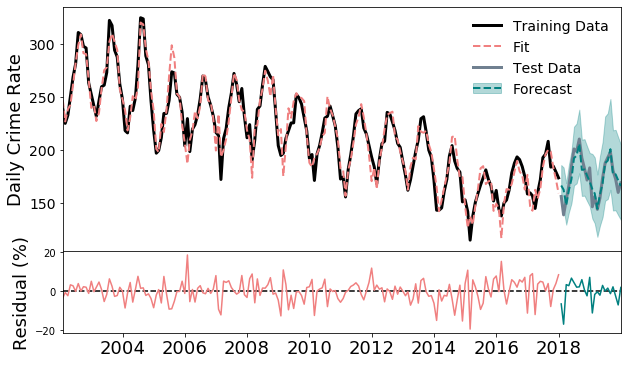

In [19]:
fig, (tax, bax) = plt.subplots(2, 1, figsize=(10, 6), 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1]})
fig.subplots_adjust(hspace=0)
# plot training data and the fit to training data
# we start plotting training data at 12 because the fit kicks in after a full period
td, = tax.plot(lin_train.iloc[12:].index, lin_train.iloc[12:], 
               lw=3, color='black', label='Training Data')
fit = 10**sarimax_fit.predict(lin_train.index[12], lin_train.index[-1])
tf, = tax.plot(lin_train.index[12:], fit,
               lw=2, color='lightcoral', ls='--', label='Fit')

# plot test data and forecast
fd, = tax.plot(lin_test.index, lin_test, lw=3, color='slategrey', 
               label='Test Data')
pred = 10**sarimax_fit.predict(lin_test.index[0], lin_test.index[-1])
ff, = tax.plot(lin_test.index, pred,
               lw=2, color='teal', ls='--', label='Forecast')

# plot 95% confidence interval for training data
forecast = sarimax_fit.get_forecast(len(lin_test))
fb = tax.fill_between(lin_test.index, *10**forecast.conf_int().transpose().values, 
                      alpha=0.3, color='teal')

# plot residuals
# training residual
res = lin_train - fit
res = res / lin_train * 100  # convert to percentage
bax.plot(res.index, res, color='lightcoral')

# test prediction error
prederr = lin_test - pred
prederr = prederr / lin_test * 100  # convert to percentage
bax.plot(prederr.index, prederr, color='teal')

# other plotting stuff
tax.set_xlim(lin_train.index[12], lin_test.index[-1])
bax.axhline(0, color='black', ls='--', zorder=0)
bax.tick_params('x', labelsize=18)
tax.set_ylabel('Daily Crime Rate', fontsize=18)
bax.set_ylabel('Residual (%)', fontsize=18)
tax.tick_params('y', labelsize=14)
# explicit handles so we can overlay two markers
# for the "Test Data" label
tax.legend(handles=[td, tf, fd, (fb, ff)], 
           labels=tax.get_legend_handles_labels()[1], 
           loc='best', fontsize=14, framealpha=0)

Overall, the seasonal ARIMA model is quite accurate. We are correctly predicting the monthly crime rate over a two year period, largely within 10% of the actual values.

### Residual analysis

Just to make sure our ARIMA fit is reasonable, let's plot the residuals (we plot the fitted data and the forecast data separately).

The plot shows the histogram of the residuals, and the best-fit normal distribution. We see that the residuals are fairly normally distrbuted, with means very close to zero. Thus, we seem to have captured all available information from the time series.

Text(0, 0.5, 'Probability')

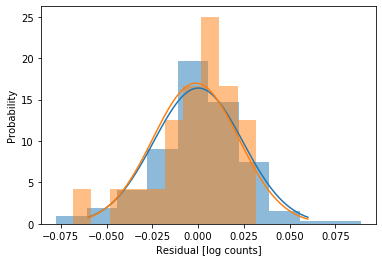

In [20]:
from scipy.stats import norm

res = train.iloc[12:] - sarimax_fit.predict(train.index[12], lin_train.index[-1])
prederr = test - sarimax_fit.predict(test.index[0], test.index[-1])
plt.hist(res, density=True, alpha=0.5)
plt.hist(prederr, density=True, alpha=0.5)
xs = np.linspace(-0.06, 0.06, 100)
plt.plot(xs, norm.pdf(xs, loc=np.mean(res), scale=np.std(res, ddof=1)), color='C0')
plt.plot(xs, norm.pdf(xs, loc=np.mean(prederr), scale=np.std(prederr, ddof=1)), color='C1')
plt.xlabel('Residual [log counts]')
plt.ylabel('Probability')

On the other hand, the autocorrelation plot suggests we may be missing something that could be improved in the model, since we see statistically significant autocorrelations.

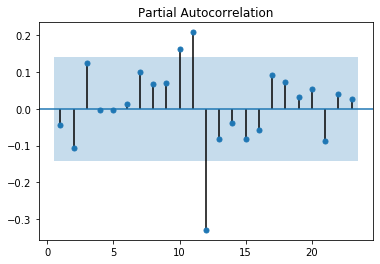

In [21]:
plot_pacf(res.dropna(), zero=False)
plt.show()

The statistical significance is confirmed for us using the [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test), which shows us that for lags $\ge11$, it is extremely likely that the autocorrelations we see are not due to chance.

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(res.dropna(), lags=np.arange(8, 24), model_df=3, return_df=True)

,lb_stat,lb_pvalue
8,8.389569,0.136032
9,8.810496,0.184519
10,13.656336,0.057642
11,19.364490,0.013027
12,41.055062,0.000005
13,41.253663,0.000010
14,42.586021,0.000013
15,45.528428,0.000008
16,45.602789,0.000017
17,49.277201,0.000008


## Additional forecasts
<a id='additional'></a>

Below we employ the same seasonal ARIMA model for other types of crime, and for specific neighborhoods. We ought to do a new hyperparameter search to determine the best order (p, d, q), (P, D, Q, s) for each new time series, as we don't necessarily expect them to behave the same. However, just as a first pass, we use the same model as before, and again fit it to years 2001 through 2017 for each crime. We show the forecast for 2018 and 2019.

This time, we wrap the model fitting in a class (`crime_arima`) for ease of use. We then do fitting and plotting in a dedicated function (`forecast_crime`).

In [23]:
class crime_arima:
    """A seasonal ARIMA model class
    
    An object-oriented wrapper around statsmodel's SARIMAX
    
    NB: Methods predict and get_forecast will inverse transform
        back to linear units if needed before returning
    """
    def __init__(self, pdq, PDQs, fit_log=True):
        """class constructor
        
        pdq : 3-tuple of (p, d, q) for ARIMA model
        PDQs : 4-tupe of (P, D, Q, s) for seasonal ARIMA 
            component
        fit_log (default True) : whether to log transform 
            time series for the fit
        """
        self.pdq = pdq
        self.PDQs = PDQs
        self.fit_log = fit_log
    
    def fit(self, series):
        """Fits the SARIMA model to the given time series
        
        series should be a datetime indexed pandas series
        """
        if self.fit_log:
            series = np.log10(series)
        sarimax = SARIMAX(series, order=self.pdq, 
                          seasonal_order=self.PDQs, trend='c')
        self.model = sarimax.fit()
        
        return self
    
    # this wrapper function allows us to inverse transform
    # the log if needed
    def inverse_transform(func):
        def return_values(self, *args, **kwargs):
            if self.fit_log:
                return 10**func(self, *args, **kwargs)
            else:
                return func(self, *args, **kwargs)
        return return_values
    
    @inverse_transform
    def predict(self, *args):
        """In sample prediction and out-of-sample forecasting"""
        return self.model.predict(*args)

    def conf_int(self, steps):
        """Out of sample confidence interval for `steps` steps"""
        forecast_obj = self.model.get_forecast(steps)
        return self._return_confidence_interval(forecast_obj)
    
    @inverse_transform
    def _return_confidence_interval(self, forecast_object):
        return forecast_object.conf_int()

In [24]:
def forecast_crime(crime_df, last_year_train=2017, plot_comparison=False):
    """Fit a seasonal ARIMA model for particular crime
    
    crime_df : the dataframe with the crime data
    last_year_train : the last year included in the training set
        the test set will be from the year after to the end
    plot_comparison : if True, plot the time series, the forecast,
        and the prediction errors
        
    Returns SARIMAX fitted model (of type SARIMAXResultsWrapper)
    """  
    # convert to time series, and split into training and test set
    # first daily counts, then mean per month
    series = crime_df.resample('1D').size().resample('1M').mean()
    train_series = series.loc[series.index < str(last_year_train + 1)]
    test_series = series.drop(index=train_series.index)
    
    # fit the model using our custom class
    model = crime_arima((2, 0, 0), (0, 1, 0, 12)).fit(train_series)
    
    if plot_comparison:
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6),
                               gridspec_kw={'height_ratios':[3, 1]})
        fig.subplots_adjust(hspace=0)
        # the original time series
        trs, = ax[0].plot(train_series.index, train_series, 
                          label='Training Data', color='black', lw=3)
        tes, = ax[0].plot(test_series.index, test_series,
                          label='Test Data', color='black', ls='--', lw=3)
        # our forecast
        pred = model.predict(test_series.index[0], test_series.index[-1])
        fr, = ax[0].plot(pred.index, pred,
                         label='Forecast', lw=3, color='teal')
        # 95% confidence interval
        fb = ax[0].fill_between(test_series.index, *model.conf_int(len(test_series)).transpose().values, 
                           alpha=0.3, color='teal')
        # plotting the prediction error
        prederr = test_series - pred
        ax[1].plot(prederr.index, prederr, color='teal')
        
        # other plot things
        ax[1].axhline(0, color='k', ls='--', zorder=0)
        ax[1].set_xlabel('')
        ax[1].tick_params('x', labelsize=15)
        ax[1].set_ylabel('Residual', fontsize=15)
        ax[0].set_ylabel(f'Daily Crime Rate', fontsize=15)
        ax[1].set_xlim(train_series.index[12], test_series.index[-1])
        ax[1].set_ylim([-1.1 * abs(prederr).max(), 1.1 * abs(prederr).max()])
        ax[0].legend(handles=[trs, tes, (fr, fb)], # overlaying two markers in one legend 
                     labels=ax[0].get_legend_handles_labels()[1],
                     loc='best', fontsize=15, framealpha=0)   
    return model

### Battery

Battery is the second most common crime (see [Notebook 1](01-chicago-crime.ipynb). The seasonal ARIMA model does fairly well predicting two years' worth of crime, despite the model parameters being chosen by cross-validation on the _theft_ time series data. The forecast does systematically underpredict the battery rate by 10% or so.

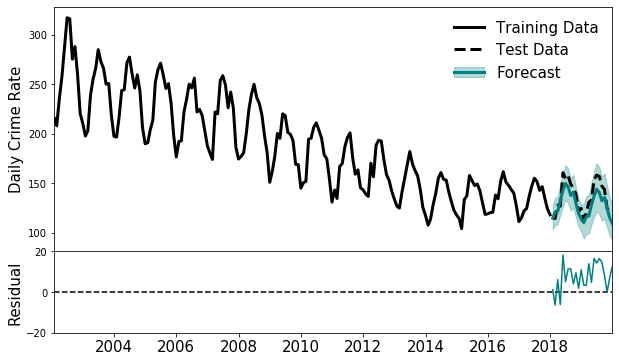

In [25]:
model = forecast_crime(crimedata.query('`Primary Type` == "BATTERY"'), plot_comparison=True)

### Petty theft

So far we've looked only at total thefts. What if we restrict to just petty theft ($\$$500 and under)?

The forecast does pretty well. The 95% confidence interval is a bit wider, but the median forecast is close to what actually happened.

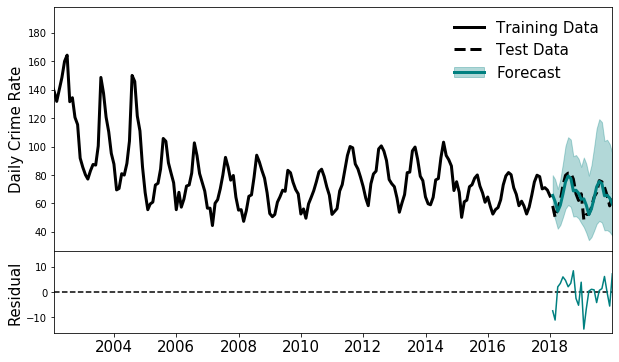

In [26]:
model = forecast_crime(crimedata.query('`Description` == "$500 AND UNDER"'), plot_comparison=True)

### Petty theft in one neighborhood

What if we look only at petty theft in the Near North Side community area? This is one of the most populous (and densely populated) community areas in Chicago.

The forecast does okay, but not as well as before. However, the confidence interval is much wider, likely owing to the noiser data overall (which stems from the lower counts when restricting the rate of petty theft to a single neighborhood).

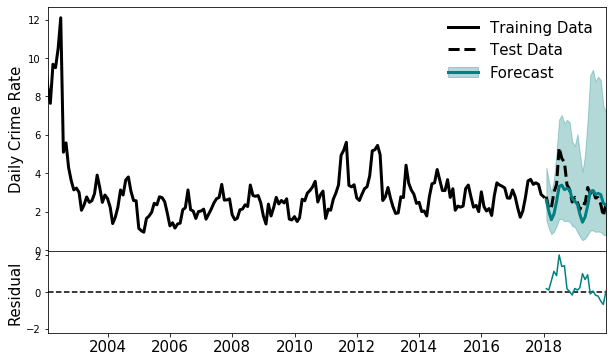

In [27]:
model = forecast_crime(crimedata.query('Description == "$500 AND UNDER" and `Community Area` == 8'), 
                       plot_comparison=True)